In [1]:
import Systems
import deepSI
from matplotlib import pyplot as plt
import numpy as np
import torch
import time
from torch import nn
import qpsolvers as qp

In [2]:
system = Systems.SinCosUnbalancedDisc(dt=0.1)

In [3]:
u = deepSI.deepSI.exp_design.multisine(100000, pmax=49999, n_crest_factor_optim=20)
u = np.clip(u*4.0, -8.0, 8.0)

In [4]:
# plt.plot(u[:500])

In [5]:
data = system.apply_experiment(deepSI.System_data(u=u))

In [6]:
# plt_len = 1000
# plt.subplot(1,4,1)
# plt.plot(data.u[:plt_len])
# plt.subplot(1,4,2)
# plt.plot(data.y[:plt_len,0])
# plt.subplot(1,4,3)
# plt.plot(data.y[:plt_len,1])
# plt.subplot(1,4,4)
# plt.plot(data.y[:plt_len,2])

In [7]:
I_enc = deepSI.fit_systems.SS_encoder_general(nx=8, na=8, nb=8, na_right=1)

In [8]:
train, test = data.train_test_split(split_fraction=0.2)
train, val  = train.train_test_split(split_fraction=0.25)

In [13]:
I_enc.fit(train_sys_data=train, val_sys_data=val, epochs=50, batch_size=256, loss_kwargs={'nf':150})

Model already initilized (init_model_done=True), skipping initilizing of the model, the norm and the creation of the optimizer
Size of the training array =  289.9 MB
N_training_samples = 59843, batch_size = 256, N_batch_updates_per_epoch = 233
Initial Validation sim-NRMS= 0.74202143330332


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch    1, sqrt loss  0.7277, Val sim-NRMS 0.7326, Time Loss: 93.6%, data: 0.2%, val: 6.2%,  3.6 batches/sec
Epoch    2, sqrt loss  0.7189, Val sim-NRMS 0.7333, Time Loss: 93.6%, data: 0.2%, val: 6.2%,  3.6 batches/sec
Epoch    3, sqrt loss  0.7158, Val sim-NRMS 0.7323, Time Loss: 93.6%, data: 0.2%, val: 6.2%,  3.6 batches/sec
Epoch    4, sqrt loss  0.7148, Val sim-NRMS 0.7318, Time Loss: 93.7%, data: 0.2%, val: 6.1%,  3.5 batches/sec
Epoch    5, sqrt loss  0.7111, Val sim-NRMS 0.7347, Time Loss: 93.6%, data: 0.2%, val: 6.2%,  3.5 batches/sec
Epoch    6, sqrt loss  0.7104, Val sim-NRMS 0.7369, Time Loss: 93.7%, data: 0.2%, val: 6.1%,  3.5 batches/sec
Epoch    7, sqrt loss  0.7059, Val sim-NRMS 0.7327, Time Loss: 93.7%, data: 0.2%, val: 6.1%,  3.5 batches/sec
Epoch    8, sqrt loss  0.7119, Val sim-NRMS 0.7308, Time Loss: 93.7%, data: 0.2%, val: 6.1%,  3.5 batches/sec
Epoch    9, sqrt loss  0.7052, Val sim-NRMS 0.7356, Time Loss: 93.7%, data: 0.2%, val: 6.1%,  3.5 batches/sec
Epoch   10

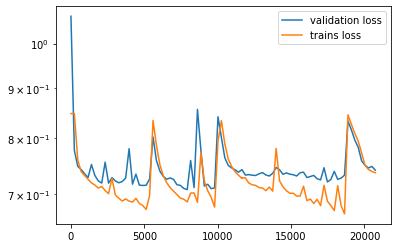

In [14]:
I_enc.checkpoint_load_system('_last')
plt.semilogy(I_enc.batch_id,I_enc.Loss_val,label='validation loss')
plt.semilogy(I_enc.batch_id,I_enc.Loss_train**0.5,label='trains loss')
plt.legend()

In [15]:
test_ss_enc = I_enc.apply_experiment(test,save_state=True)

NRMS simulation SS linear  88.49%


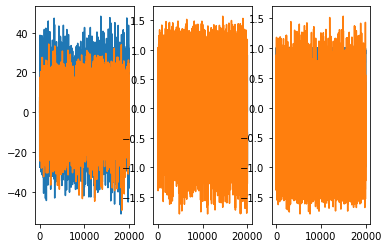

In [16]:
print(f'NRMS simulation SS linear  {test_ss_enc.NRMS(test):.2%}')

plt.subplot(1,3,1)
plt.plot(test.y[:,0])
plt.plot(test.y[:,0] - test_ss_enc.y[:,0])

plt.subplot(1,3,2)
plt.plot(test.y[:,1])
plt.plot(test.y[:,1] - test_ss_enc.y[:,1]);

plt.subplot(1,3,3)
plt.plot(test.y[:,2])
plt.plot(test.y[:,2] - test_ss_enc.y[:,2]);

In [ ]:
nsteperror = I_enc.n_step_error(test,nf=200) #return in NRMS units of fit_sys_ss_enc.norm
plt.plot(nsteperror)
plt.xlabel('n step in the future')
plt.ylabel('NRMS error')
plt.show()

In [ ]:
I_enc.save_system("systems/SinCos_dt01_nab_4_e200")